 # Attribution Patching Demo
 **Read [the accompanying blog post here](https://neelnanda.io/attribution-patching) for more context**
 This is an interim research report, giving a whirlwind tour of some unpublished work I did at Anthropic (credit to the then team - Chris Olah, Catherine Olsson, Nelson Elhage and Tristan Hume for help, support, and mentorship!)

 The goal of this work is run activation patching at an industrial scale, by using gradient based attribution to approximate the technique - allow an arbitrary number of patches to be made on two forwards and a single backward pass

 I have had less time than hoped to flesh out this investigation, but am writing up a rough investigation and comparison to standard activation patching on a few tasks to give a sense of the potential of this approach, and where it works vs falls down.

 <b style="color: red">To use this notebook, go to Runtime > Change Runtime Type and select GPU as the hardware accelerator.</b>

 **Tips for reading this Colab:**
 * You can run all this code for yourself!
 * The graphs are interactive!
 * Use the table of contents pane in the sidebar to navigate
 * Collapse irrelevant sections with the dropdown arrows
 * Search the page using the search in the sidebar, not CTRL+F

 ## Setup (Ignore)

In [1]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEBUG_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install transformer_lens
    %pip install torchtyping
    # Install my janky personal plotting utils
    %pip install git+https://github.com/neelnanda-io/neel-plotly.git
    # Install another version of node that makes PySvelte work way faster
    !sudo apt-get install -y nodejs
    %pip install git+https://github.com/austinleedavis/PySvelte-fixColabSetup.git
    # Needed for PySvelte to work, v3 came out and broke things...
    %pip install typeguard==2.13.3
except:
    IN_COLAB = False
    %env NODE_OPTIONS=--openssl-legacy-provider # nodejs is SOOO janky wtf bro
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython
    %pip install transformer_lens
    %pip install torchtyping
    # Install my janky personal plotting utils
    %pip install git+https://github.com/neelnanda-io/neel-plotly.git
    %pip install git+https://github.com/austinleedavis/PySvelte-fixColabSetup.git
    # Needed for PySvelte to work, v3 came out and broke things...
    %pip install typeguard==2.13.3
    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

env: NODE_OPTIONS=--openssl-legacy-provider # nodejs is SOOO janky wtf bro
Running as a Jupyter notebook - intended for development only!

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/neelnanda-io/neel-plotly.git to /private/var/folders/tv/bgwf6pv92m935jtjh44g8bmr0000gn/T/pip-req-build-wf24tpub
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/neel-plotly.git /private/var/folders/tv/bgwf6pv92m935jtjh44g8bmr0000gn/T/pip-req-build-wf24tpub
  Resolved https://github.com/neelnanda-io/neel-plotly.git to commit 6dc24b26f8dec991908479d7445dae496b3430b7
  Preparing metadata (setup.py) ... done



/var/folders/tv/bgwf6pv92m935jtjh44g8bmr0000gn/T/ipykernel_81221/3292126430.py:30: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/var/folders/tv/bgwf6pv92m935jtjh44g8bmr0000gn/T/ipykernel_81221/3292126430.py:31: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


In [2]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio

if IN_COLAB or not DEBUG_MODE:
    # Thanks to annoying rendering issues, Plotly graphics will either show up in colab OR Vscode depending on the renderer - this is bad for developing demos! Thus creating a debug mode.
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"

In [3]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from torchtyping import TensorType as TT
from typing import List, Union, Optional, Callable
from functools import partial
import copy
import itertools
import json

from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML, Markdown

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [4]:
import pysvelte
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

 Plotting helper functions from a janky personal library of plotting utils. The library is not documented and I recommend against trying to read it, just use your preferred plotting library if you want to do anything non-obvious:

In [5]:
from neel_plotly import line, imshow, scatter

In [6]:
import transformer_lens.patching as patching

 ## IOI Patching Setup
 This just copies the relevant set up from Exploratory Analysis Demo, and isn't very important.

In [7]:
model = HookedTransformer.from_pretrained("gpt2-small")
model.set_use_attn_result(True)

Loaded pretrained model gpt2-small into HookedTransformer


In [10]:
# hack to consider just the first one for now
prompts = ['When John and Mary went to the shops, John gave the bag to', 'When John and Mary went to the shops, Mary gave the bag to']#,'When Tom and James went to the park, James gave the ball to', 'When Tom and James went to the park, Tom gave the ball to', 'When Dan and Sid went to the shops, Sid gave an apple to', 'When Dan and Sid went to the shops, Dan gave an apple to', 'After Martin and Amy went to the park, Amy gave a drink to', 'After Martin and Amy went to the park, Martin gave a drink to']
answers = [(' Mary', ' John') ]#, (' John', ' Mary'), (' Tom', ' James'), (' James', ' Tom'), (' Dan', ' Sid'), (' Sid', ' Dan'), (' Martin', ' Amy'), (' Amy', ' Martin')]

clean_tokens = model.to_tokens(prompts)
# Swap each adjacent pair, with a hacky list comprehension
corrupted_tokens = clean_tokens[
    [(i+1 if i%2==0 else i-1) for i in range(len(clean_tokens)) ]
    ]
print("Clean string 0", model.to_string(clean_tokens[0]))
print("Corrupted string 0", model.to_string(corrupted_tokens[0]))

answer_token_indices = torch.tensor([[model.to_single_token(answers[i][j]) for j in range(2)] for i in range(len(answers))], device=model.cfg.device)
print("Answer token indices", answer_token_indices)

Clean string 0 <|endoftext|>When John and Mary went to the shops, John gave the bag to
Corrupted string 0 <|endoftext|>When John and Mary went to the shops, Mary gave the bag to
Answer token indices tensor([[5335, 1757]])


In [11]:
def get_logit_diff(logits, answer_token_indices=answer_token_indices):
    if len(logits.shape)==3:
        # Get final logits only
        logits = logits[:, -1, :]
    correct_logits = logits.gather(1, answer_token_indices[:, 0].unsqueeze(1))
    incorrect_logits = logits.gather(1, answer_token_indices[:, 1].unsqueeze(1))
    return (correct_logits - incorrect_logits).mean()

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)

clean_logit_diff = get_logit_diff(clean_logits, answer_token_indices).item()
print(f"Clean logit diff: {clean_logit_diff:.4f}")

corrupted_logit_diff = get_logit_diff(corrupted_logits, answer_token_indices).item()
print(f"Corrupted logit diff: {corrupted_logit_diff:.4f}")

Clean logit diff: 3.3367
Corrupted logit diff: -3.2016


In [12]:
CLEAN_BASELINE = clean_logit_diff
CORRUPTED_BASELINE = corrupted_logit_diff
def ioi_metric(logits, answer_token_indices=answer_token_indices):
    return (get_logit_diff(logits, answer_token_indices) - CORRUPTED_BASELINE) / (CLEAN_BASELINE  - CORRUPTED_BASELINE)

print(f"Clean Baseline is 1: {ioi_metric(clean_logits).item():.4f}")
print(f"Corrupted Baseline is 0: {ioi_metric(corrupted_logits).item():.4f}")

Clean Baseline is 1: 1.0000
Corrupted Baseline is 0: 0.0000


 ## Patching
 In the following cells, we define attribution patching and use it in various ways on the model.

In [13]:
Metric = Callable[[TT["batch_and_pos_dims", "d_model"]], float]

In [14]:
filter_not_qkv_input = lambda name: "_input" not in name and "attn_in" not in name and "hook_mlp_in" not in name
def get_cache_fwd_and_bwd(model, tokens, metric):
    model.reset_hooks()
    cache = {}
    def forward_cache_hook(act, hook):
        cache[hook.name] = act.detach()
    model.add_hook(filter_not_qkv_input, forward_cache_hook, "fwd")

    grad_cache = {}
    def backward_cache_hook(act, hook):
        grad_cache[hook.name] = act.detach()
    model.add_hook(filter_not_qkv_input, backward_cache_hook, "bwd")

    value = metric(model(tokens))
    value.backward()
    model.reset_hooks()
    return value.item(), ActivationCache(cache, model), ActivationCache(grad_cache, model)

clean_value, clean_cache, clean_grad_cache = get_cache_fwd_and_bwd(model, clean_tokens, ioi_metric)
print("Clean Value:", clean_value)
print("Clean Activations Cached:", len(clean_cache))
print("Clean Gradients Cached:", len(clean_grad_cache))
corrupted_value, corrupted_cache, corrupted_grad_cache = get_cache_fwd_and_bwd(model, corrupted_tokens, ioi_metric)
print("Corrupted Value:", corrupted_value)
print("Corrupted Activations Cached:", len(corrupted_cache))
print("Corrupted Gradients Cached:", len(corrupted_grad_cache))

print(f"Clean cache: {clean_cache}")
print(f"Clean grad cache: {clean_grad_cache}")
print(f"Corrupted cache: {corrupted_cache}")
print(f"Corrupted grad cache: {corrupted_grad_cache}")

Clean Value: 1.0
Clean Activations Cached: 220
Clean Gradients Cached: 220
Corrupted Value: 0.0
Corrupted Activations Cached: 220
Corrupted Gradients Cached: 220
Clean cache: ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.attn.hook_result', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.attn.hook_result', 

In [15]:
def get_shape_of_activation(name: str) -> tuple:
    shape = clean_cache[name].shape
    assert shape == clean_grad_cache[name].shape
    return shape

 ## Validating Attribution vs Activation Patching
 Let's now compare attribution and activation patching. Generally it's a decent approximation! The main place it fails is MLP0 and the residual stream
 My fuzzy intuition is that attribution patching works badly for "big" things which are poorly modelled as linear approximations, and works well for "small" things which are more like incremental changes. Anything involving replacing the embedding is a "big" thing, which includes residual streams, and in GPT-2 small MLP0 seems to be used as an "extended embedding" (where later layers use MLP0's output instead of the token embedding), so I also count it as big.
 See more discussion in the accompanying blog post!


 First do some refactoring to make attribution patching more generic. We make an attribution cache, which is an ActivationCache where each element is (clean_act - corrupted_act) * corrupted_grad, so that it's the per-element attribution for each activation. Thanks to linearity, we just compute things by adding stuff up along the relevant dimensions!

In [16]:
attribution_cache_dict = {}
for key in corrupted_grad_cache.cache_dict.keys():
    attribution_cache_dict[key] = corrupted_grad_cache.cache_dict[key] * (clean_cache.cache_dict[key] - corrupted_cache.cache_dict[key])
attr_cache = ActivationCache(attribution_cache_dict, model)

 By block: For each head we patch the starting residual stream, attention output + MLP output

In [17]:
str_tokens = model.to_str_tokens(clean_tokens[0])
context_length = len(str_tokens)

In [18]:
every_block_act_patch_result = patching.get_act_patch_block_every(model, corrupted_tokens, clean_cache, ioi_metric)
imshow(every_block_act_patch_result, facet_col=0, facet_labels=["Residual Stream", "Attn Output", "MLP Output"], title="Activation Patching Per Block", xaxis="Position", yaxis="Layer", zmax=1, zmin=-1, x= [f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))])

  0%|                                                                      | 0/180 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|████████████████████████████████████████████████████████████| 180/180 [01:00<00:00,  2.99it/s]


In [19]:
def get_attr_patch_block_every(attr_cache):
    resid_pre_attr = einops.reduce(
        attr_cache.stack_activation("resid_pre"),
        "layer batch pos d_model -> layer pos",
        "sum",
    )
    attn_out_attr = einops.reduce(
        attr_cache.stack_activation("attn_out"),
        "layer batch pos d_model -> layer pos",
        "sum",
    )
    mlp_out_attr = einops.reduce(
        attr_cache.stack_activation("mlp_out"),
        "layer batch pos d_model -> layer pos",
        "sum",
    )

    every_block_attr_patch_result = torch.stack([resid_pre_attr, attn_out_attr, mlp_out_attr], dim=0)
    return every_block_attr_patch_result
every_block_attr_patch_result =  get_attr_patch_block_every(attr_cache)
imshow(every_block_attr_patch_result, facet_col=0, facet_labels=["Residual Stream", "Attn Output", "MLP Output"], title="Attribution Patching Per Block", xaxis="Position", yaxis="Layer", zmax=1, zmin=-1, x= [f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))])

In [20]:
scatter(y=every_block_attr_patch_result.reshape(3, -1), x=every_block_act_patch_result.reshape(3, -1), facet_col=0, facet_labels=["Residual Stream", "Attn Output", "MLP Output"], title="Attribution vs Activation Patching Per Block", xaxis="Activation Patch", yaxis="Attribution Patch", hover=[f"Layer {l}, Position {p}, |{str_tokens[p]}|" for l in range(model.cfg.n_layers) for p in range(context_length)], color=einops.repeat(torch.arange(model.cfg.n_layers), "layer -> (layer pos)", pos=context_length), color_continuous_scale="Portland")

 By head: For each head we patch the output, query, key, value or pattern. We do all positions at once so it's not super slow.

In [21]:
every_head_all_pos_act_patch_result = patching.get_act_patch_attn_head_all_pos_every(model, corrupted_tokens, clean_cache, ioi_metric)
imshow(every_head_all_pos_act_patch_result, facet_col=0, facet_labels=["Output", "Query", "Key", "Value", "Pattern"], title="Activation Patching Per Head (All Pos)", xaxis="Head", yaxis="Layer", zmax=1, zmin=-1)

100%|████████████████████████████████████████████████████████████| 144/144 [00:55<00:00,  2.58it/s]


In [22]:
def get_attr_patch_attn_head_all_pos_every(attr_cache):
    head_out_all_pos_attr = einops.reduce(
        attr_cache.stack_activation("z"),
        "layer batch pos head_index d_head -> layer head_index",
        "sum",
    )
    head_q_all_pos_attr = einops.reduce(
        attr_cache.stack_activation("q"),
        "layer batch pos head_index d_head -> layer head_index",
        "sum",
    )
    head_k_all_pos_attr = einops.reduce(
        attr_cache.stack_activation("k"),
        "layer batch pos head_index d_head -> layer head_index",
        "sum",
    )
    head_v_all_pos_attr = einops.reduce(
        attr_cache.stack_activation("v"),
        "layer batch pos head_index d_head -> layer head_index",
        "sum",
    )
    head_pattern_all_pos_attr = einops.reduce(
        attr_cache.stack_activation("pattern"),
        "layer batch head_index dest_pos src_pos -> layer head_index",
        "sum",
    )

    return torch.stack([head_out_all_pos_attr, head_q_all_pos_attr, head_k_all_pos_attr, head_v_all_pos_attr, head_pattern_all_pos_attr])

every_head_all_pos_attr_patch_result = get_attr_patch_attn_head_all_pos_every(attr_cache)
imshow(every_head_all_pos_attr_patch_result, facet_col=0, facet_labels=["Output", "Query", "Key", "Value", "Pattern"], title="Attribution Patching Per Head (All Pos)", xaxis="Head", yaxis="Layer", zmax=1, zmin=-1)

In [23]:
HEAD_NAMES = [f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)]
HEAD_NAMES_SIGNED = [f"{name}{sign}" for name in HEAD_NAMES for sign in ["+", "-"]]
HEAD_NAMES_QKV = [f"{name}{act_name}" for name in HEAD_NAMES for act_name in ["Q", "K", "V"]]

scatter(y=every_head_all_pos_attr_patch_result.reshape(5, -1), x=every_head_all_pos_act_patch_result.reshape(5, -1), facet_col=0, facet_labels=["Output", "Query", "Key", "Value", "Pattern"], title="Attribution vs Activation Patching Per Head (All Pos)", xaxis="Activation Patch", yaxis="Attribution Patch", include_diag=True, hover=HEAD_NAMES, color=einops.repeat(torch.arange(model.cfg.n_layers), "layer -> (layer head)", head=model.cfg.n_heads), color_continuous_scale="Portland")

 We see pretty good results in general, but significant errors for heads L5H5 on query and moderate errors for head L10H7 on query and key, and moderate errors for head L11H10 on key. But each of these is fine for pattern and output. My guess is that the problem is that these have pretty saturated attention on a single token, and the linear approximation is thus not great on the attention calculation here, but I'm not sure. When we plot the attention patterns, we do see this!
 Note that the axis labels are for the *first* prompt's tokens, but each facet is a different prompt, so this is somewhat inaccurate. In particular, every odd facet has indirect object and subject in the opposite order (IO first). But otherwise everything lines up between the prompts (This text is from Neel)

In [24]:
graph_tok_labels = [f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))]
imshow(clean_cache["pattern", 5][:, 5], x= graph_tok_labels, y=graph_tok_labels, facet_col=0, title="Attention for Head L5H5", facet_name="Prompt")
imshow(clean_cache["pattern", 10][:, 7], x= graph_tok_labels, y=graph_tok_labels, facet_col=0, title="Attention for Head L10H7", facet_name="Prompt")
imshow(clean_cache["pattern", 11][:, 10], x= graph_tok_labels, y=graph_tok_labels, facet_col=0, title="Attention for Head L11H10", facet_name="Prompt")


# [markdown]

# Defining a head to look at

In [48]:
inspect_layer = 9
inspect_head = 9

# Attention Pattern Patching
https://www.neelnanda.io/mechanistic-interpretability/attribution-patching#attention-pattern-patching

In [49]:
import pandas as pd
from itertools import product
# thanks ChatGPT!

# Assuming you want to create a DataFrame for layer 5, head_index 5, and all combinations of dest_pos and src_pos from 0 to 14
layer = [inspect_layer]
head_index = [inspect_head]
dest_pos = [i for i in range(15)]
src_pos = [i for i in range(15)]

# Create all combinations
combinations = product(layer, head_index, dest_pos, src_pos)

# Create DataFrame from combinations
head_we_want = pd.DataFrame(combinations, columns=["layer", "head_index", "dest_pos", "src_pos"])

# Now you can use head_we_want as the index_df in your function
our_head_patched = patching.generic_activation_patch(model, corrupted_tokens, clean_cache, ioi_metric, patch_setter=patching.layer_head_dest_src_pos_pattern_patch_setter,activation_name="pattern", index_df=head_we_want)
our_head_patched = our_head_patched.reshape((15, 15))

100%|████████████████████████████████████████████████████████████| 225/225 [03:08<00:00,  1.19it/s]


In [50]:
print(corrupted_tokens)

tensor([[50256,  2215,  1757,   290,  5335,  1816,   284,   262, 12437,    11,
          5335,  2921,   262,  6131,   284],
        [50256,  2215,  1757,   290,  5335,  1816,   284,   262, 12437,    11,
          1757,  2921,   262,  6131,   284]])


# Calculating Hessian

It can be useful to calculate the diagonal of the Hessian ($\frac{\partial^2 L}{\partial x_i^2}$) when we are doing linear approximations. The higher the magnitude of the second derivative, the worse the linear approximation is.

In [51]:
from tqdm.auto import tqdm
def get_2nd_derivative_attn(model, tokens, metric, hook_name_for_2nd_derivative, batch=0, head=0):
    model.reset_hooks()
    cache = {}

    def forward_cache_hook(act, hook):
        act.requires_grad_()
        cache[hook.name] = act
    model.add_hook(filter_not_qkv_input, forward_cache_hook, "fwd")

    grad_cache = {}

    def backward_cache_hook(act, hook):
        grad_cache[hook.name] = act

    model.add_hook(filter_not_qkv_input, backward_cache_hook, "bwd")

    # Compute metric and backward pass
    value = metric(model(tokens))
    value.backward(create_graph=True)
    act_cache = ActivationCache(cache, model)
    gradient_cache = ActivationCache(grad_cache, model)
    t = torch.zeros((15 * 15, 15 * 15)) # 15^2 b/c we flatten the 2nd derivative so its easier to manipulate
    for i in range(15):
        for j in range(15):
            s = (batch, head, i, j)
            gradient = torch.autograd.grad(grad_cache[hook_name_for_2nd_derivative][s], cache[hook_name_for_2nd_derivative], allow_unused=True, retain_graph=True)[0][batch, head] # we don't use s because we want to capture *all* the partial derivatives so that we can construct the hessian
            flat = gradient.flatten()
            t[i * 15 + j] = flat
    model.reset_hooks()
    return t, value.item(), act_cache, gradient_cache


snd_dir, value, act_cache, grad_cache = get_2nd_derivative_attn(model, clean_tokens, ioi_metric, f'blocks.{inspect_layer}.attn.hook_pattern', batch=0, head=inspect_head)

In [52]:
# since we harvested the hessian, now we have to calculate the 2nd order taylor to the approximation (to see where attr patching fails)
head_attn = (clean_cache['blocks.5.attn.hook_pattern'][0, inspect_head].flatten() - corrupted_cache['blocks.5.attn.hook_pattern'][0, inspect_head].flatten())
# first, let's clean everything up by flattening the matrices so we can construct a proper hessian matrix
correction = (1/2) * head_attn * (snd_dir @ head_attn) # ChatGPT said this was correct, it seems to be doing what we want
correction_2d = correction.detach().reshape((15, 15))
print(correction_2d.shape)

torch.Size([15, 15])


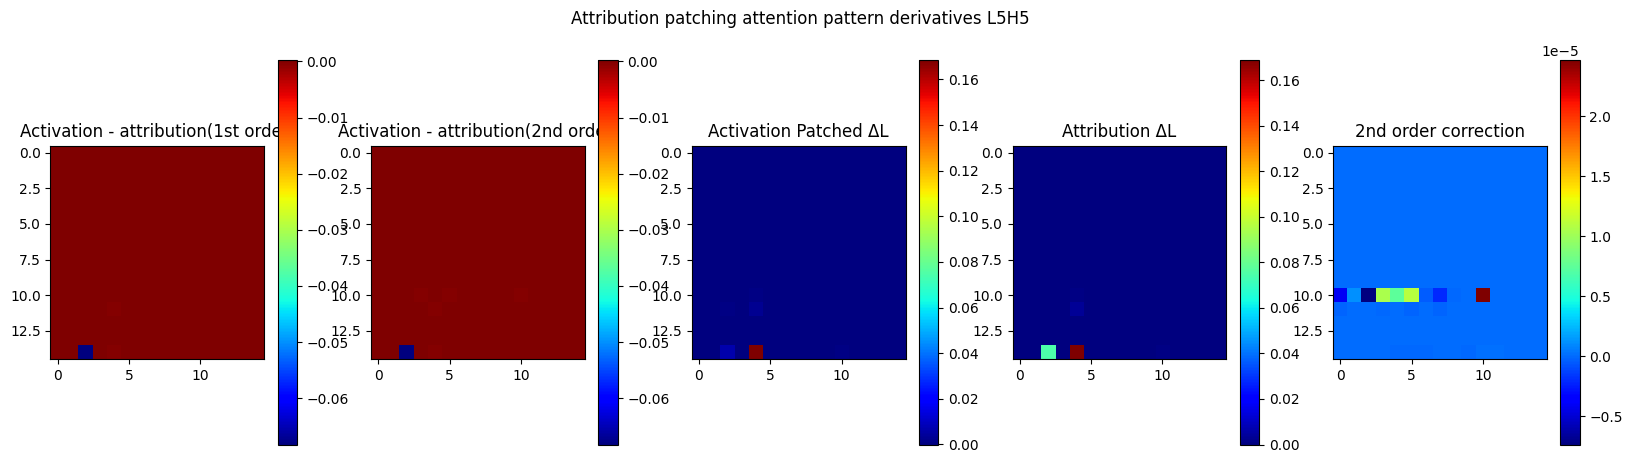

In [53]:
# BIG TODO: the mistake here is that for all these to be consistent with eachother, we either need to sum over all batches (which is costly to activation patch and compute Hessian on), or we just need to do the 0th example (might be better to start)

import matplotlib.pyplot as plt
# snd_dir_to_display = torch.nn.functional.softmax(torch.abs(snd_dir) * 100000, dim=1) # hacky normalization since the display requires it adds up to 1
# grad_to_display = torch.nn.functional.softmax(torch.abs(grad_cache['blocks.1.attn.hook_attn_scores'].detach()[0,0]) * 100000, dim=1) # hacky normalization since the display requires it adds up to 1
# display(pysvelte.AttentionMulti(tokens=model.to_str_tokens(clean_tokens[0]), attention=torch.stack((act_cache['blocks.1.attn.hook_attn_scores'].detach()[0,0], grad_to_display, snd_dir_to_display)).permute(1,2,0), head_labels=["L1H0 act", "L1H0 grad", "L1H0 hess"]))

# Data to be visualized
data = [
    our_head_patched - attr_cache[f'blocks.{inspect_layer}.attn.hook_pattern'][0, inspect_head],
    our_head_patched - (correction_2d + attr_cache[f'blocks.{inspect_layer}.attn.hook_pattern'][0, inspect_head]),
    our_head_patched,
    attr_cache[f'blocks.{inspect_layer}.attn.hook_pattern'][0, inspect_head],
    correction_2d,
 #   act_cache[f'blocks.{inspect_layer}.attn.hook_pattern'][0, inspect_head].detach()
]

# Labels for each facet
facet_labels = ["Activation - attribution(1st order)","Activation - attribution(2nd order)","Activation Patched ΔL","Attribution ΔL", "2nd order correction"]

# Create subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

# Plot each facet with its own color scale
for i, ax in enumerate(axs):
    im = ax.imshow(data[i], cmap='jet')
    ax.title.set_text(facet_labels[i])
    plt.colorbar(im, ax=ax)

plt.suptitle("Attribution patching attention pattern derivatives L5H5")
plt.show()